In [ ]:
# 1. Imports e Configuração
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping

# 2. Montar Drive e Descompactar (O segredo da velocidade!)
drive.mount('/content/drive')

# AJUSTE O CAMINHO DO SEU ZIP AQUI
zip_path = '/content/drive/MyDrive/Imagens_Supeita_Sauron.zip'
extract_path = '/content/dataset_local'

if not os.path.exists(extract_path):
    print("Descompactando imagens...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Pronto!")

base_dir = os.path.join(extract_path, 'Imagens_Supeita_Sauron')

# 3. Carregar Datasets (Copiando a lógica de divisão 80/10/10)
BATCH_SIZE = 32
IMG_SIZE = (150, 150) # DenseNet foi projetado para 224, mas como é muito profunda e demora no treino usarei 150

dataset_total = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    label_mode='binary'
)

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset_total)

# Otimização de I/O
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Mounted at /content/drive
Descompactando imagens...
Pronto!
Found 27558 files belonging to 2 classes.


In [ ]:
# 1. Data Augmentation (Sempre bom manter)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
])

# 2. Pré-processamento específico da DenseNet
# A DenseNet tem sua própria função de tratamento de pixels
preprocess_input = tf.keras.applications.densenet.preprocess_input

# 3. Baixar o Modelo Base (DenseNet121)
base_model = applications.DenseNet121(input_shape=IMG_SIZE + (3,),
                                      include_top=False,
                                      weights='imagenet')

# 4. CONGELAR o modelo base
# Importante! Não queremos estragar o que ela já sabe.
base_model.trainable = False

# 5. Montar o Modelo Final
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x) # Transforma os pixels de 0-255 para -1 a 1
x = base_model(x, training=False) # Passa pela DenseNet
x = layers.GlobalAveragePooling2D()(x) # Resume as características em um vetor
x = layers.Dropout(0.2)(x) # Evita overfitting
outputs = layers.Dense(1, activation='sigmoid')(x) # Nossa decisão final

model_tl = tf.keras.Model(inputs, outputs)

# 6. Compilar
base_learning_rate = 0.001 # Taxa baixa para começar
model_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_tl.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 3. Treinar a Fase 1 (Feature Extraction)
history_tl = model_tl.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 117s 113ms/step - accuracy: 0.7783 - loss: 0.4533 - val_accuracy: 0.8932 - val_loss: 0.2585
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.8803 - loss: 0.2907 - val_accuracy: 0.8986 - val_loss: 0.2414
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.8887 - loss: 0.2717 - val_accuracy: 0.8968 - val_loss: 0.2462
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8888 - loss: 0.2691 - val_accuracy: 0.9099 - val_loss: 0.2225
Epoch 5/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.8958 - loss: 0.2595 - val_accuracy: 0.9110 - val_loss: 0.2178
Epoch 6/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8925 - loss: 0.2647 - val_accuracy: 0.8903 - val_loss: 0.2589
Epoch 7/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8942 - loss: 0.2695 - val_accuracy: 0.9106 - val_loss: 0.2171
Epoch 8/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8950 - loss: 0.2581 

In [ ]:
# 1. Descongelar o modelo base
base_model.trainable = True

# 2. Verificar quantas camadas existem
print(f"Número de camadas no base model: {len(base_model.layers)}")

# 3. Escolher a partir de onde descongelar
# A DenseNet tem cerca de 420 camadas. Vamos treinar apenas as últimas 30.
# Isso mantém as características básicas (bordas, formas) intactas e treina só o final.
fine_tune_at = len(base_model.layers) - 30

# Congela todas as camadas ANTES
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 4. Recompilar com Learning Rate MUITO BAIXA (Crucial!)
# Usamos 1/10 ou 1/100 da taxa original para fazer ajustes finos.
model_tl.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), # Taxa bem pequena
              metrics=['accuracy'])

model_tl.summary()

Número de camadas no base model: 427


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 642,433 (2.45 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

In [ ]:
# Configurar Early Stopping para esta fase também
early_stopping_fine = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Definir quantas épocas a mais queremos tentar
fine_tune_epochs = 30
total_epochs =  14 + fine_tune_epochs # 14 da fase anterior + novas tentativas

print(f"Iniciando Fine Tuning da época 14 até no máximo {total_epochs}...")

history_fine = model_tl.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=14,
    validation_data=val_dataset,
    callbacks=[early_stopping_fine]
)

Iniciando Fine Tuning da época 14 até no máximo 44...
Epoch 15/44
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 84ms/step - accuracy: 0.8495 - loss: 0.4600 - val_accuracy: 0.8983 - val_loss: 0.2782
Epoch 16/44
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.8819 - loss: 0.3156 - val_accuracy: 0.9153 - val_loss: 0.2396
Epoch 17/44
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.8876 - loss: 0.3035 - val_accuracy: 0.9182 - val_loss: 0.2201
Epoch 18/44
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.8924 - loss: 0.2994 - val_accuracy: 0.9197 - val_loss: 0.2122
Epoch 19/44
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.8934 - loss: 0.2986 - val_accuracy: 0.9222 - val_loss: 0.2070
Epoch 20/44
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.9034 - loss: 0.2561 - val_accuracy: 0.9233 - val_loss: 0.2038
Epoch 21/44
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.9046 - loss: 0.2677 - val_accuracy: 0.9255 - val_loss: 0.1998
Epoch 22/44
689/689 ━━━━━━━━━

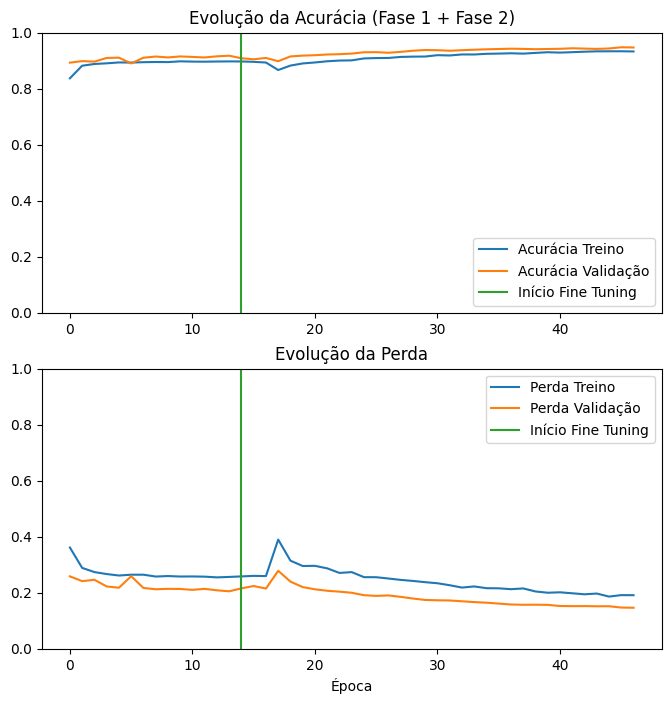

In [ ]:
# Recuperar os dados da fase 1
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']
loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

# Adicionar os dados da fase 2
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))

# Gráfico de Acurácia
plt.subplot(2, 1, 1)
plt.plot(acc, label='Acurácia Treino')
plt.plot(val_acc, label='Acurácia Validação')
plt.ylim([0, 1])
plt.plot([14, 14], plt.ylim(), label='Início Fine Tuning') # Linha vertical na época 14
plt.legend(loc='lower right')
plt.title('Evolução da Acurácia (Fase 1 + Fase 2)')

# Gráfico de Perda
plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda Treino')
plt.plot(val_loss, label='Perda Validação')
plt.ylim([0, 1.0])
plt.plot([14, 14], plt.ylim(), label='Início Fine Tuning')
plt.legend(loc='upper right')
plt.title('Evolução da Perda')
plt.xlabel('Época')
plt.show()

In [ ]:
loss, accuracy = model_tl.evaluate(test_dataset)
print(f'Acurácia Final no Teste: {accuracy*100:.2f}%')

if accuracy > 0.85:
    model_tl.save('modelo_sauron_densenet_final.keras')
    print("Modelo salvo com sucesso!")

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9472 - loss: 0.1711
Acurácia Final no Teste: 94.53%
Modelo salvo com sucesso!
